### 共享单车-租车人数的关联因素分析
- 特征工程概念
- 日期型变量的处理
- 相关性分析

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import calendar
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format="retina"

In [3]:
BikeData=pd.read_csv("sharebike.csv",sep=",")
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### 数据字段描述
- datatime - 日期+时间
- season - 1=春天，2=夏天，3=秋天，4=冬天
- holiday - 是否是节假日
- workingday - 1=工作日 0=周末
- weather -
    - 1：晴天，多云
    - 2：雾天，阴天
    - 3：小雪，小雨
    - 4：大雨，大雪，大雾
- temp - 气温摄氏度
- atemp - 体感温度
- humidity - 湿度
- windspeed - 风速
- casual - 非注册用户个数
- registered - 注册用户个数
- count - 给定日期时间（每小时）总租车人数，是casual和registered的求和。

### 1. 观察数据
1. 数据大小                 (df.shape)
2. head, tail数据          (df.head()  df.tail())
3. 各字段数据类型与缺失值     (df.info())

In [21]:
BikeData.shape

(10886, 12)

In [22]:
BikeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


- 数据10886行，12列，占据空间1M
- 各字段无缺失值

In [5]:
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
BikeData.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012/12/19 19:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012/12/19 20:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012/12/19 21:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012/12/19 22:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012/12/19 23:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


- 数据记录时间从2011年1月一直到2012年12月，近两年的数据
- 两年的数量，可以较为客观地分析该城市共享单车用户端情况

### 2. 日期型变量的处理

In [8]:
# 日期变量的处理
ex=BikeData.datetime[0]
ex.split()[0]

'2011/1/1'

In [4]:
# 自定义函数获取日期
def get_date(x):
    return x.split()[0]
# 对指定字段应用自定义函数apply()
BikeData["date"]=BikeData.datetime.apply(get_date)

BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011/1/1
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011/1/1
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011/1/1
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011/1/1
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011/1/1


In [5]:
# 自定义函数获取时间
def get_hour(x):
    hour=x.split()[1].split(":")[0]
    int_hour=int(hour) # 注意，这里的hour要转换为数值型，因为字符串型在排序时不按数值型排序规则来
    return int_hour

BikeData["hour"]=BikeData.datetime.apply(get_hour)
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011/1/1,0
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011/1/1,1
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011/1/1,2
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011/1/1,3
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011/1/1,4


In [6]:
# calneder包中的day_name，列举周一至周日
calendar.day_name[:]

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [9]:
dateStr=ex.split()[0]

# 调用datetime包（不是字段）中的strptime函数，将字符串格式的dateStr转换为日期时间类型
# "%Y/%m/%d"指定输入日期的格式，这里只dateStr的格式2011/1/1
dateDT=datetime.strptime(dateStr,"%Y/%m/%d")
dateDT

datetime.datetime(2011, 1, 1, 0, 0)

In [10]:
# a.weekday,取出日期a对应的星期数
# 0~6对应周一~周日
week_day=dateDT.weekday()
week_day

5

In [11]:
# 整合上面两部，自定义函数获取日期对应的星期数
def get_weekday(x):
    dateStr=x.split()[0]
    dateDT=datetime.strptime(dateStr,"%Y/%m/%d")
    week_day=dateDT.weekday()
    return week_day

BikeData["weekday"]=BikeData.datetime.apply(get_weekday)
BikeData.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday
10881,2012/12/19 19:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012/12/19,19,2
10882,2012/12/19 20:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012/12/19,20,2
10883,2012/12/19 21:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012/12/19,21,2
10884,2012/12/19 22:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012/12/19,22,2
10885,2012/12/19 23:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012/12/19,23,2


In [12]:
# 同样的，自定义函数获取日期对应的月份
# 这里也可以使用切片+split的方法得到月份  x.split()[0].split("/")[1]
def get_month(x):
    dateStr=x.split()[0]
    dateDT=datetime.strptime(dateStr,"%Y/%m/%d")
    month=dateDT.month
    return month

BikeData["month"]=BikeData.datetime.apply(get_month)
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011/1/1,0,5,1
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011/1/1,1,5,1
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011/1/1,2,5,1
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011/1/1,3,5,1
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011/1/1,4,5,1


- 至此，对数据进行了观察，并处理日期变量datetime，新增了日期、小时、星期数、月份这4个字段

### 3. 相关性分析（Correlation Analysis)
- 相关分析是一种基于不同特征相关系数的分析，帮助理解特征如何影响应变量

#### 3.1 相关系数
相关系数是一个介于[-1,1]之间的一个实数。
简单来说：
- 0表示没有线性相关性
- 负数表示一个值变大则另一个值有变小的趋势
- 正数表示一个值变大则另一个值有变大的趋势
- 相关系数的绝对值大小决定了这种线性相关性的强弱

In [15]:
# df.corr()计算dataframe中各字段的相关系数
# 相关系数矩阵对角线的值永远为1，因为是特征本身与自己的相关系数 
# 相关系数矩阵是一个对称矩阵，我们只需要看上三角部分或者下三角部分即可
correlation=BikeData[["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","casual","registered","count"]].corr()
correlation

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


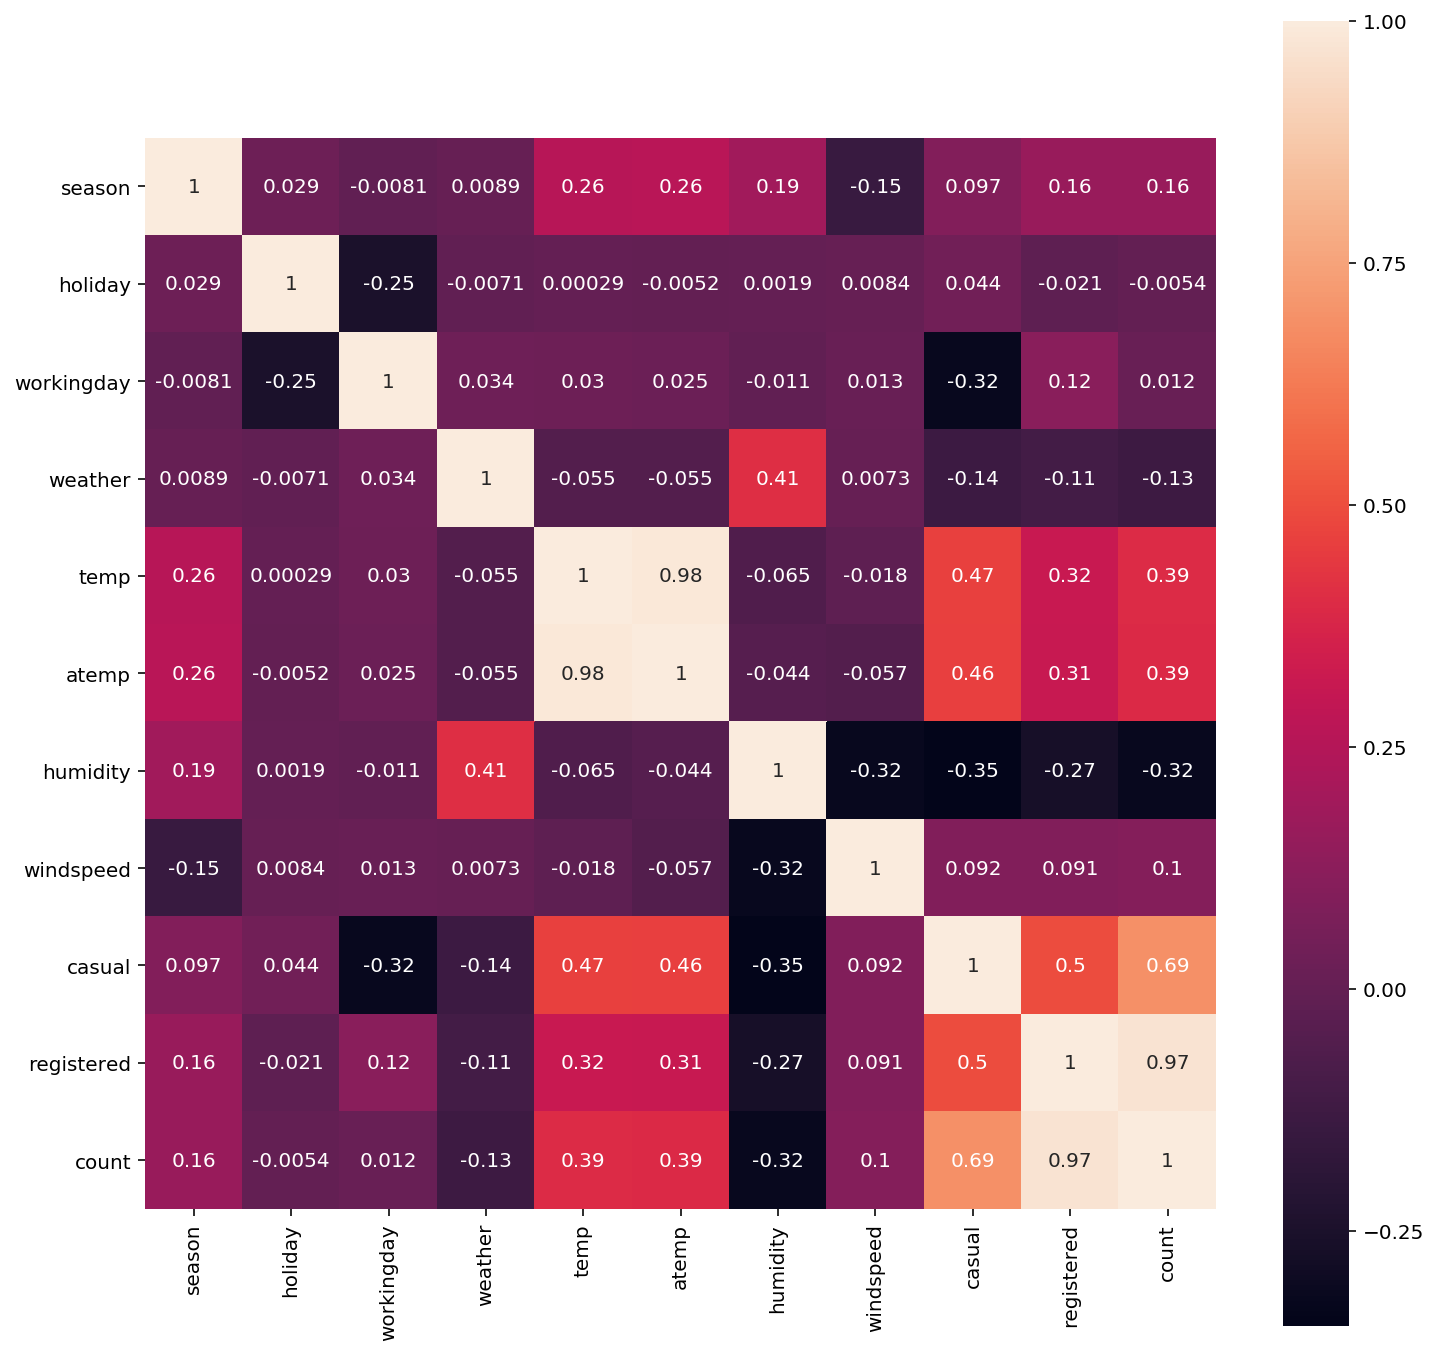

In [16]:
fig=plt.figure(figsize=(12,12))

# 使用热地图(heat map)更直观地展示系数矩阵情况
# vmax设定热地图色块的最大区分值
# square设定图片为正方形与否
# annot设定是否显示每个色块的系数值
sns.heatmap(correlation,vmax=1,square=True,annot=True)

- count（租车人数）：温度、体感温度与租车人数正相关-寒冷抑制租车需求；湿度与人数负相关-雨雪天气抑制租车需求；注册人数、非注册人数与租车人数强正相关-转化率问题，用户越多，租车需求越多；
- registered（注册用户数）：温度高、工作日，刺激民众成为注册用户-租车的需求可能更多的是非寒冷天气的通勤；非注册用户与注册用户数强正相关-先试用再转化，是一种商业模式；
- temp（气温）：气温和体温强正相关-当然气温越高体温越高
- season（季节）：春季更干燥、低温

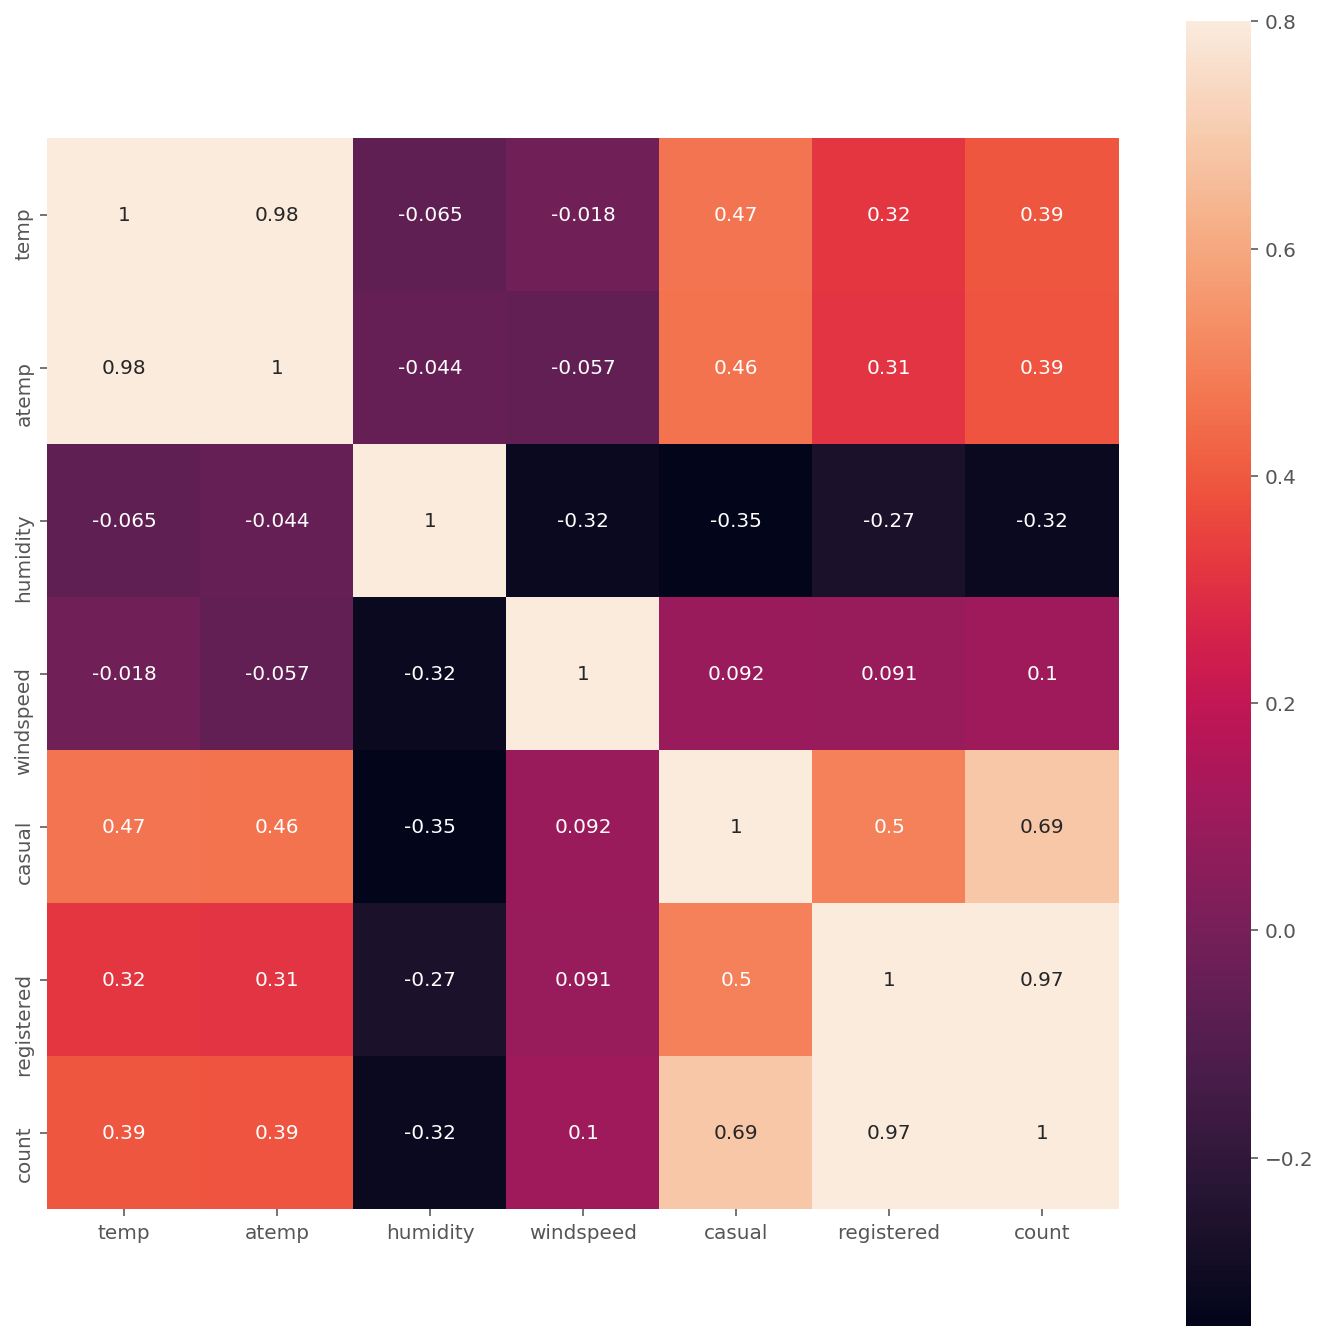

In [66]:
correlation2=BikeData[["temp","atemp","humidity","windspeed","casual","registered","count"]].corr()
fig=plt.figure(figsize=(12,12))
sns.heatmap(correlation2,vmax=.8,square=True,annot=True)

#### 3.2 拟合线性回归

- 线性回归是利用数理统计中回归分析，来确定两种或两种以上变量间相互依赖的定量关系的一种统计分析方法
- 拟合一条直线更好的帮助我们查看趋势，可以证明直线的斜率就是相关系数

> 思考：三维、多维回归

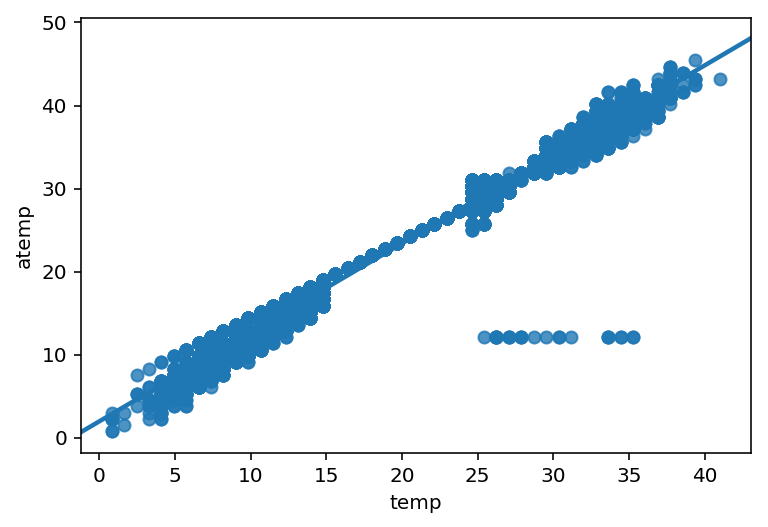

In [17]:
sns.regplot(data=BikeData,x="temp",y="atemp")

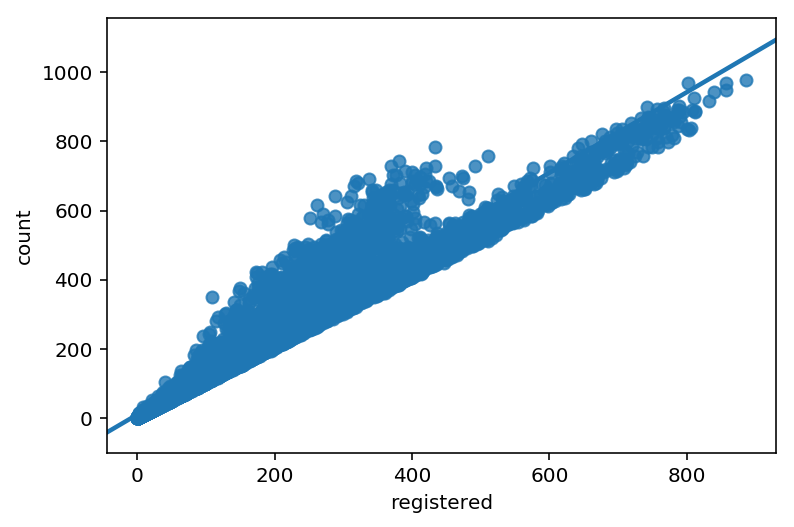

In [13]:
sns.regplot(data=BikeData,x="registered",y="count")

### 4. 可视化分析
- 租车人数在各分类变量下的箱线图
- 连续变量（temp\atemp\humidity\windspeed\casual\registered）与租车人数的关系
- 不同季节下，各小时段的租车人数情况
- 工作日与否，各小时租车人数情况
- 不同天气情况下，各月份的租车人数

#### 4.1 租车人数在各分类变量下的箱线图
- 租车人数箱线图（小时为单位）
- 各月份租车人数箱线图
- 各星期数租车人数箱线图
- 各小时（0~23时）租车人数箱线图
- 各季节租车人数箱线图
- 各天气租车人数箱线图
- 节假日与否的租车人数箱线图
- 周末与否的租车人数箱线图

- 想将season字段1234替换为春夏秋冬，但代码执行有问题，考虑正则替换

> for i in range(len(BikeData.season)):
    if BikeData.season[i]==1:
        BikeData.season[i]="Spring"
    elif BikeData.season[i]==2:
        BikeData.season[i]="Summer"
    elif BikeData.season[i]==3:
        BikeData.season[i]="Autumn"
    elif BikeData.season[i]==4:
        BikeData.season[i]="Winter"
    else:
        continue

- 其实可以使用映射函数serries.map({old:new,old:new})实现

> BikeData['holiday_cat'] = BikeData['holiday'].map( {0: 'non-holiday', 1: 'holiday'} )

In [40]:
BikeData[["count"]].describe()

,count
count,10886.000000
mean,191.574132
std,181.144454
min,1.000000
25%,42.000000
50%,145.000000
75%,284.000000
max,977.000000


In [43]:
BikeData.describe(include=[np.object])

,datetime,date
count,10886,10886
unique,10886,456
top,2012/6/5 21:00,2011/1/13
freq,1,24


[Text(0,0.5,'Count'),
 Text(0.5,0,'Workingday'),
 Text(0.5,1,'box plot on count across workingday')]

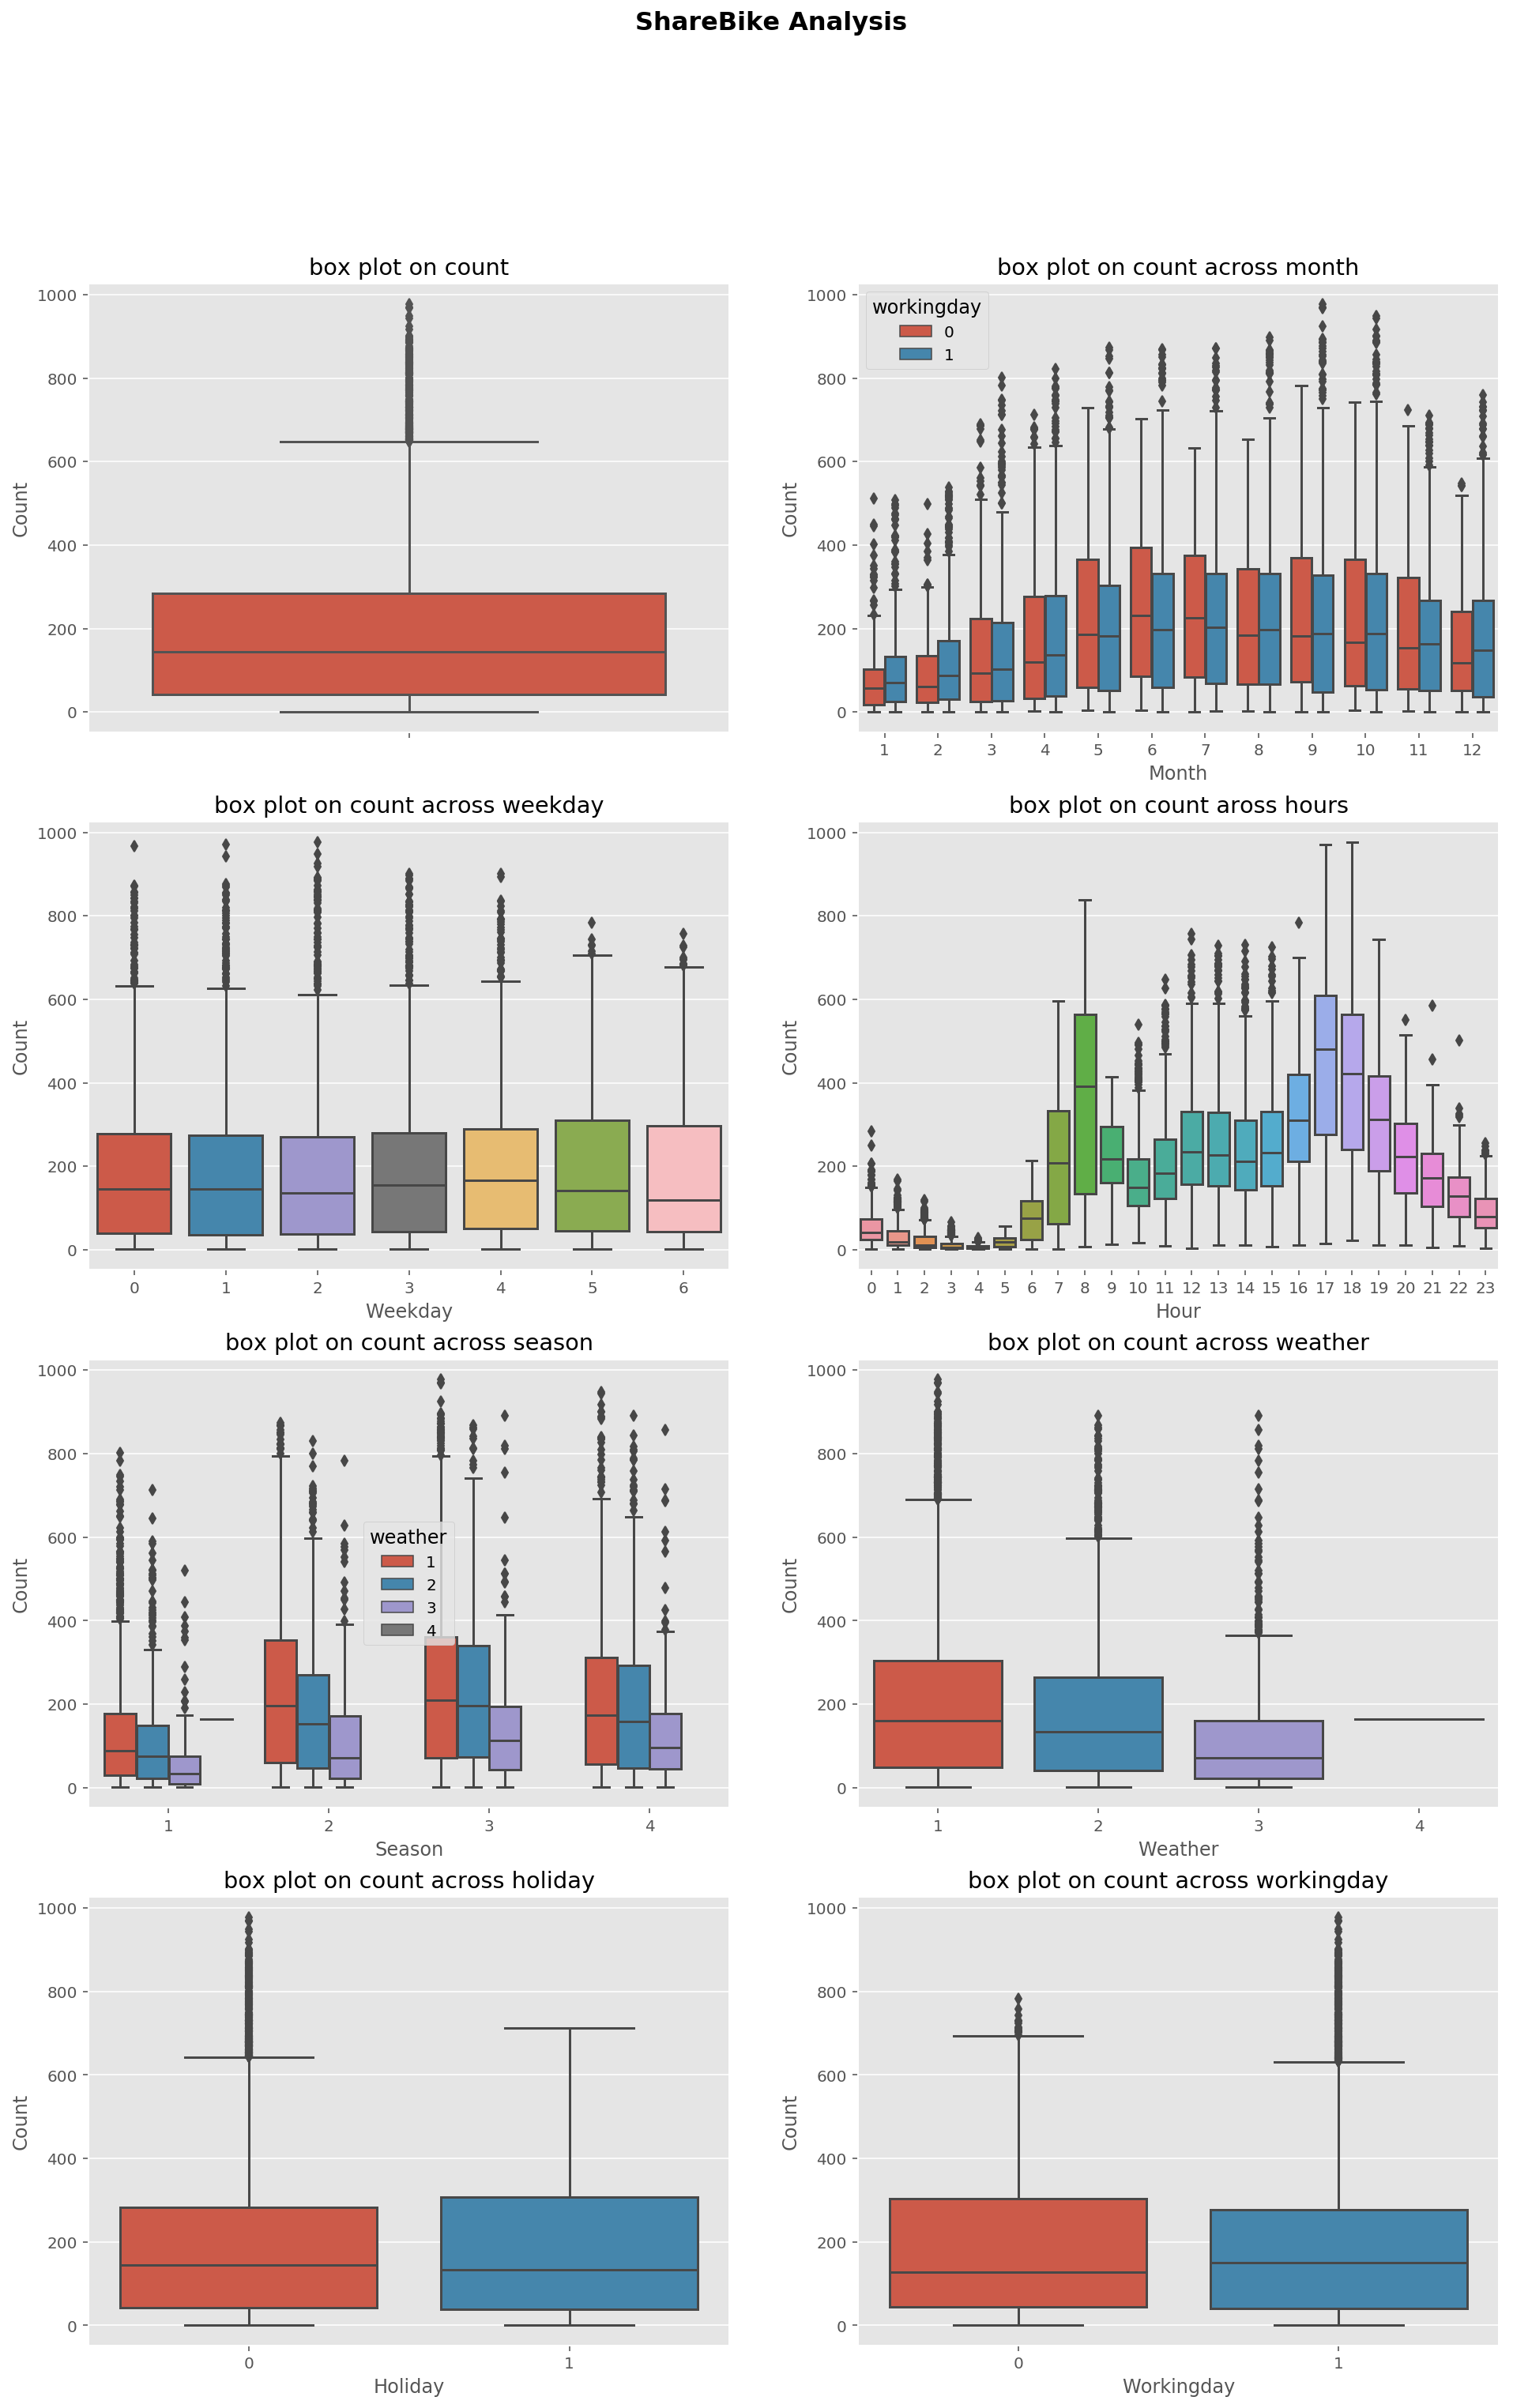

In [19]:
# 绘制多图
plt.style.use("ggplot")
fig=plt.figure(figsize=(16,24))

# 设置图像大标题
fig.suptitle("ShareBike Analysis",fontsize=16,fontweight="bold")

# 添加第一个子图
ax1=fig.add_subplot(4,2,1)
sns.boxplot(data=BikeData,y="count")
plt.title("box plot on count")
plt.ylabel("Count")


# 添加第二个子图
ax2=fig.add_subplot(4,2,2)
sns.boxplot(data=BikeData,x="month",y="count",hue="workingday")
ax2.set(ylabel="Count",xlabel="Month",title="box plot on count across month")


# 添加第三个子图
ax3=fig.add_subplot(4,2,3)
sns.boxplot(data=BikeData,x="weekday",y="count")
ax3.set(ylabel="Count",xlabel="Weekday",title="box plot on count across weekday")


# 添加第四个子图
ax4=fig.add_subplot(4,2,4)
sns.boxplot(data=BikeData,x="hour",y='count')

# 下面两句代码与ax2.set()效果一样
# plt.title("box plot on count")
# plt.ylabel("Count")
ax4.set(ylabel="Count",xlabel="Hour",title="box plot on count aross hours")


# 添加第五个子图
ax5=fig.add_subplot(4,2,5)
sns.boxplot(data=BikeData,x="season",y="count",hue="weather")
ax5.set(ylabel="Count",xlabel="Season",title="box plot on count across season")


# 添加第六个子图
ax6=fig.add_subplot(4,2,6)
sns.boxplot(data=BikeData,x="weather",y="count")
ax6.set(ylabel="Count",xlabel="Weather",title="box plot on count across weather")


# 添加第七个子图
ax7=fig.add_subplot(4,2,7)
sns.boxplot(data=BikeData,x="holiday",y="count")
ax7.set(ylabel="Count",xlabel="Holiday",title="box plot on count across holiday")


# 添加第八个子图
ax8=fig.add_subplot(4,2,8)
sns.boxplot(data=BikeData,x="workingday",y="count")
ax8.set(ylabel="Count",xlabel="Workingday",title="box plot on count across workingday")

- 每小时的租车人数中位数在150上下；
- 寒冷季节（1,2,12月），工作日租车人数高于非工作日，看来寒冷季节租车以通勤为主，那么冷的天，周末当然是窝在家里啦；温暖、凉爽季节（5-11月），非工作日租车人数高于工作日，看来这些季节租车以游玩为主，春暖花开、夏日蝉鸣、秋高气爽，当然要骑车车出去玩耍啦；
- 租车高峰时段为早上的7、8、9点和下午的5、6、7点，正好是上下班高峰期；
- 春季租车人数少，可能是乍暖还寒，人们不愿意出门，并且这段时间正好赶上中国春节，大城市人口外流，租车需求减少；
- 天气越好，租车的人越多，暴雨暴雪一般没有人租车；

#### 4.2 连续变量（temp\atemp\humidity\windspeed）与租车人数的关系
- 温度、湿度对租车人数的影响（什么样的温度湿度下租车的人最多）（由于体感温度和气温强正相关，因此选择一个因素分析即可）
- 温度、风速 v.s. 租车人数
- 湿度、风速 v.s. 租车人数

> 连续变量离散化前，先观察连续变量的统计分布情况，再决定如何离散处理

In [15]:
BikeData[["temp","atemp","humidity","windspeed"]].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


In [20]:
# 连续变量离散化，使用pd.cut分为5段
BikeData["temp_band"]=pd.cut(BikeData["temp"],4)
BikeData["humidity_band"]=pd.cut(BikeData["humidity"],5)
BikeData["windspeed_band"]=pd.cut(BikeData["windspeed"],5)
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,temp_band,humidity_band,windspeed_band
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011/1/1,0,5,1,"(0.78, 10.865]","(80.0, 100.0]","(-0.057, 11.399]"
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011/1/1,1,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]"
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011/1/1,2,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]"
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011/1/1,3,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]"
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011/1/1,4,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]"


In [46]:
BikeData.windspeed_band.value_counts()

(-0.057, 11.399]    5396
(11.399, 22.799]    4367
(22.799, 34.198]     976
(34.198, 45.598]     138
(45.598, 56.997]       9
Name: windspeed_band, dtype: int64

In [47]:
type(BikeData.windspeed_band[0])

pandas._libs.interval.Interval

#### 气温、湿度、天气 v.s. 租车人数

In [21]:
# 将季节1234对应到春夏秋冬（使用映射函数.map）
BikeData["season_word"]=BikeData["season"].map({1:"Spring",2:"Summer",3:"Autumn",4:"Winter"})
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,temp_band,humidity_band,windspeed_band,season_word
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011/1/1,0,5,1,"(0.78, 10.865]","(80.0, 100.0]","(-0.057, 11.399]",Spring
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011/1/1,1,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011/1/1,2,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011/1/1,3,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011/1/1,4,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring


E:\Users\AW\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

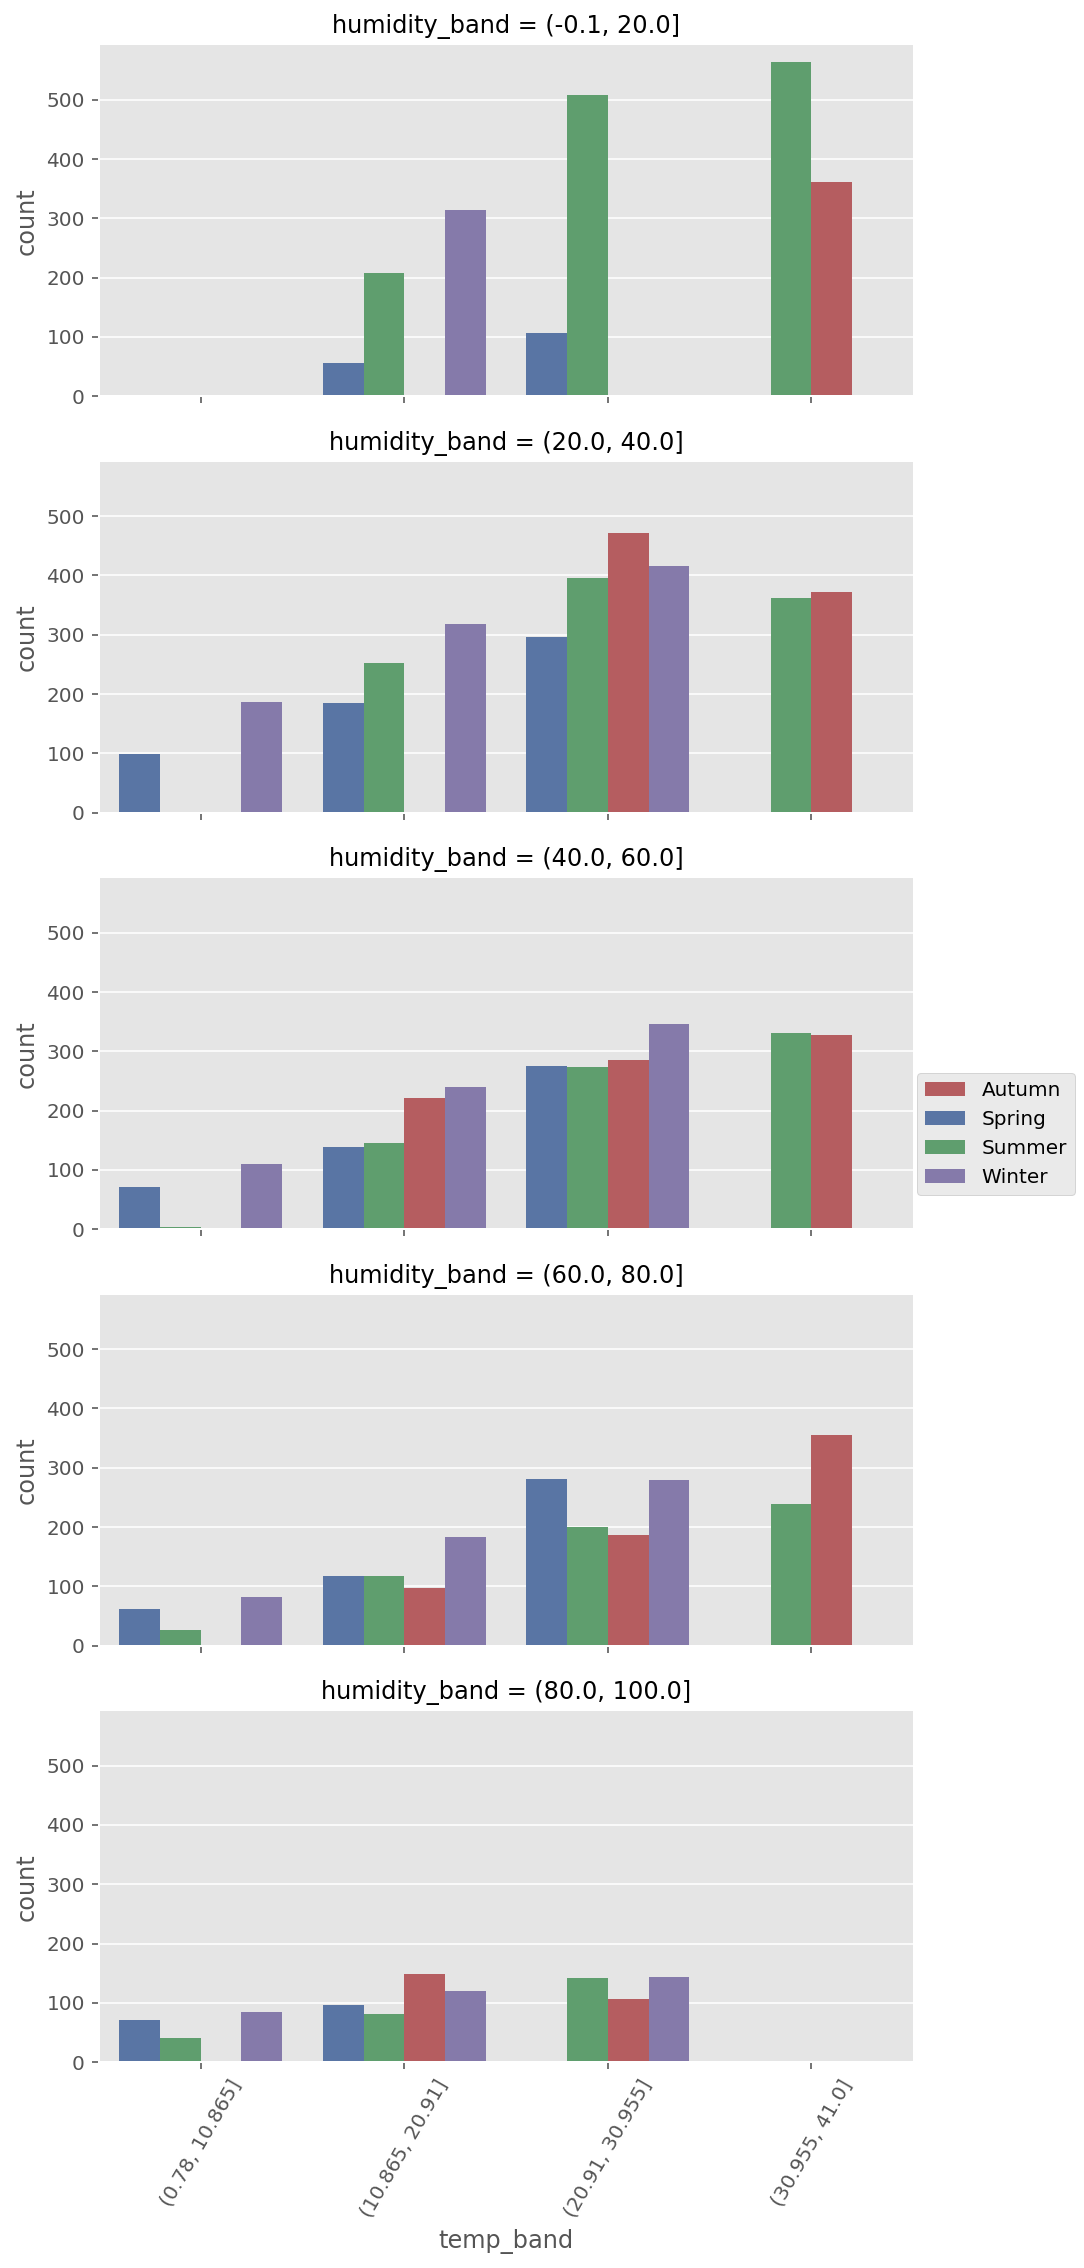

In [22]:
sns.FacetGrid(data=BikeData,row="humidity_band",aspect=2.2).\
map(sns.barplot,"temp_band","count","season_word",hue_order=["Spring","Summer","Autumn","Winter"],palette="deep",ci=None).\
add_legend()
plt.xticks(rotation=60)

- 气温低于10，高于30度，租车人数较少-太冷太热都会抑制租车需求
- 空气湿度越高，租车人数越少-干爽的天气骑车比较舒适
- 干燥的夏天、湿润的冬天，秋天是租车需求比较旺盛的时期

#### 不同季节下，各小时段的租车人数情况

E:\Users\AW\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


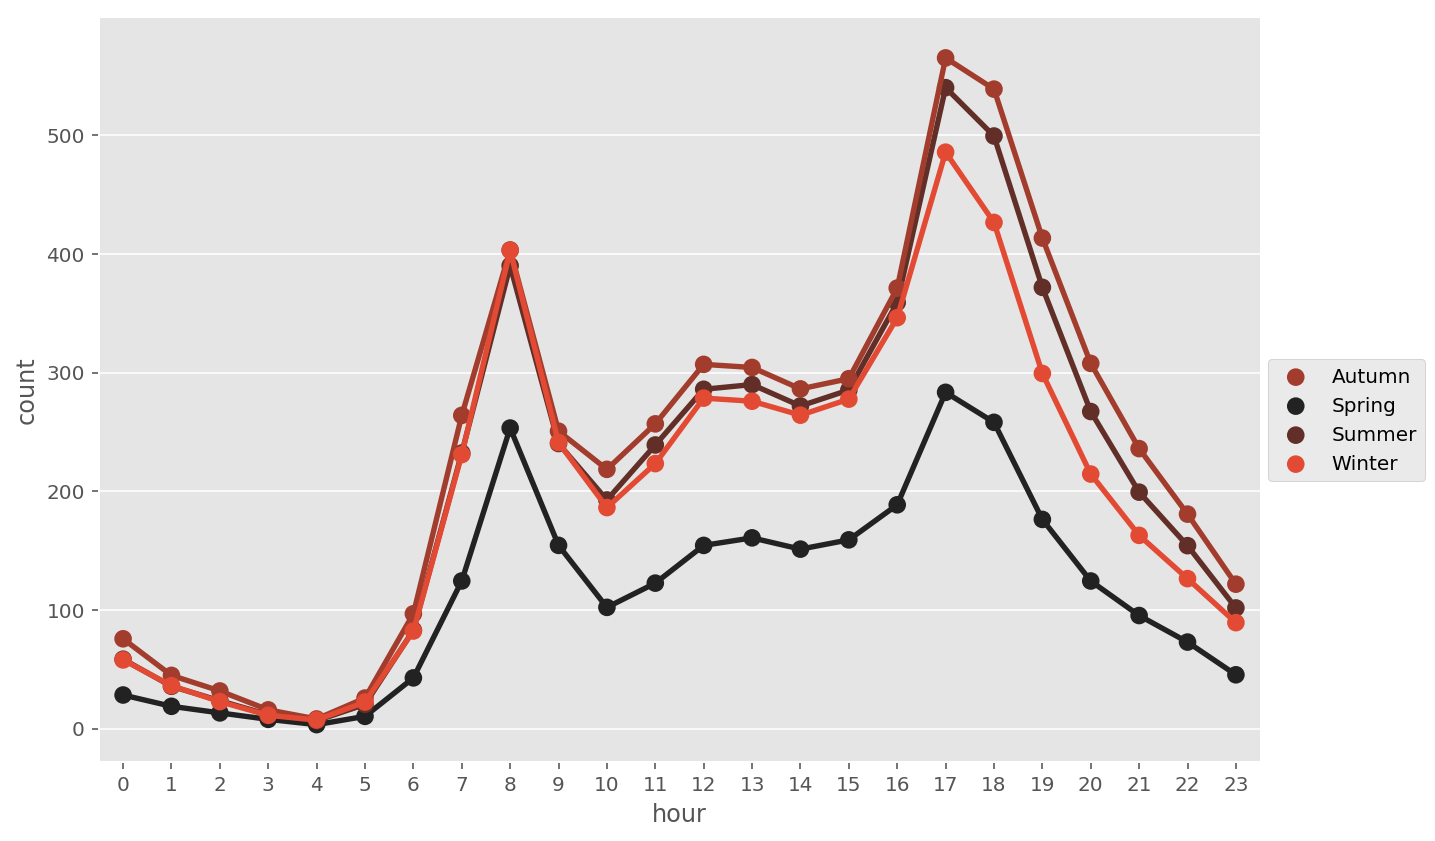

In [23]:
plt.style.use("ggplot")

sns.FacetGrid(data=BikeData,size=6,aspect=1.5).\
map(sns.pointplot,"hour","count","season_word",hue_order=["Spring","Summer","Autumn","Winter"],paletter="deep",ci=None).\
add_legend()

- 不论季节，每天早晨7-9点，傍晚16-19点是租车高峰期，分别在8点和17点达到时段峰值
- 工作时段的租车人数处于一天中的中间水平，夜幕降临后，租车人数逐渐减少-夜晚寒冷、阴暗，骑车不便利
- 春季用车人数总体较少，夏秋季最多

#### 工作日与否，各小时租车人数情况

E:\Users\AW\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


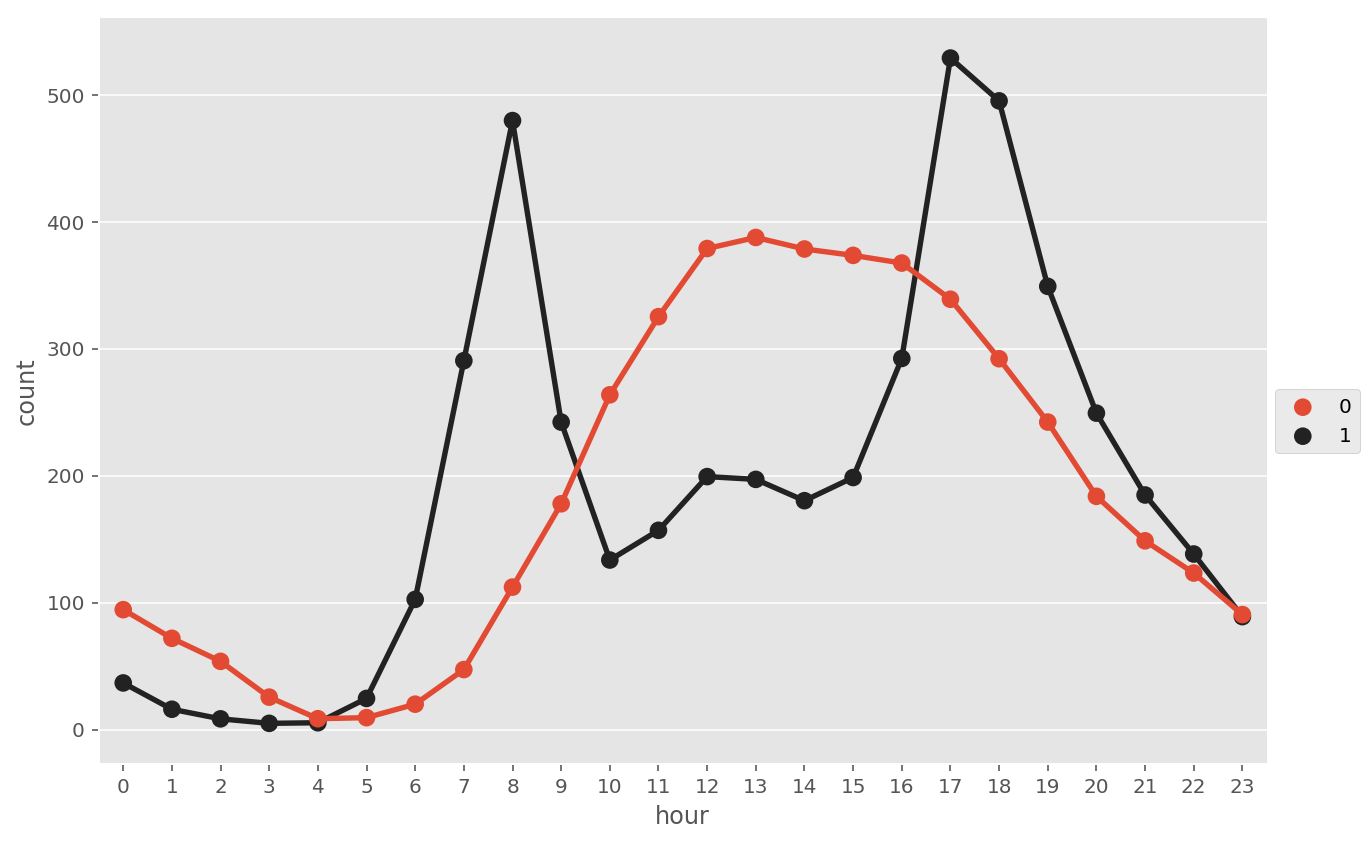

In [24]:
sns.FacetGrid(data=BikeData,size=6,aspect=1.5).\
map(sns.pointplot,"hour","count","workingday",hue_order=[1,0],paletter="deep",ci=None).\
add_legend()

- 是否是工作日，对于用车高峰时段的影响非常大
- 工作日的租车高峰时段非常明显，处于7-9点，16-19点-通勤为主
- 非工作日租车高峰时段特征较为平缓，从上午10点租车人数逐渐增多，到晚上8点后，租车人数回到低峰水平-非工作日主要用于休闲代步、短途旅游等（大家起床都很迟嘛）

#### 不同天气情况下，各月份的租车人数

In [25]:
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,temp_band,humidity_band,windspeed_band,season_word
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011/1/1,0,5,1,"(0.78, 10.865]","(80.0, 100.0]","(-0.057, 11.399]",Spring
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011/1/1,1,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011/1/1,2,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011/1/1,3,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011/1/1,4,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring


In [30]:
BikeData["weather_word"]=BikeData["weather"].map({1:"sunny",2:"foggy",3:"rainy",4:"stormy"})
BikeData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,date,hour,weekday,month,temp_band,humidity_band,windspeed_band,season_word,weather_word
0,2011/1/1 0:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,2011/1/1,0,5,1,"(0.78, 10.865]","(80.0, 100.0]","(-0.057, 11.399]",Spring,sunny
1,2011/1/1 1:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,2011/1/1,1,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring,sunny
2,2011/1/1 2:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,2011/1/1,2,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring,sunny
3,2011/1/1 3:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,2011/1/1,3,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring,sunny
4,2011/1/1 4:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,2011/1/1,4,5,1,"(0.78, 10.865]","(60.0, 80.0]","(-0.057, 11.399]",Spring,sunny


In [31]:
# 数据透视表呈现
BikeData[["count","month","weather_word"]].pivot_table(values="count",index="month",columns="weather_word",aggfunc="mean")

weather_word,foggy,rainy,stormy,sunny
month,,,,
1,77.679654,44.983333,164.0,99.792230
2,108.008439,76.352273,NaN,115.965278
3,133.052632,55.571429,NaN,164.358714
4,145.609959,83.868421,NaN,212.729730
5,197.020906,135.546392,NaN,247.071970
6,236.333333,161.431373,NaN,249.574156
7,237.135484,182.230769,NaN,237.818942
8,243.876923,180.952381,NaN,236.330275
9,216.826772,130.443299,NaN,259.501792


E:\Users\AW\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


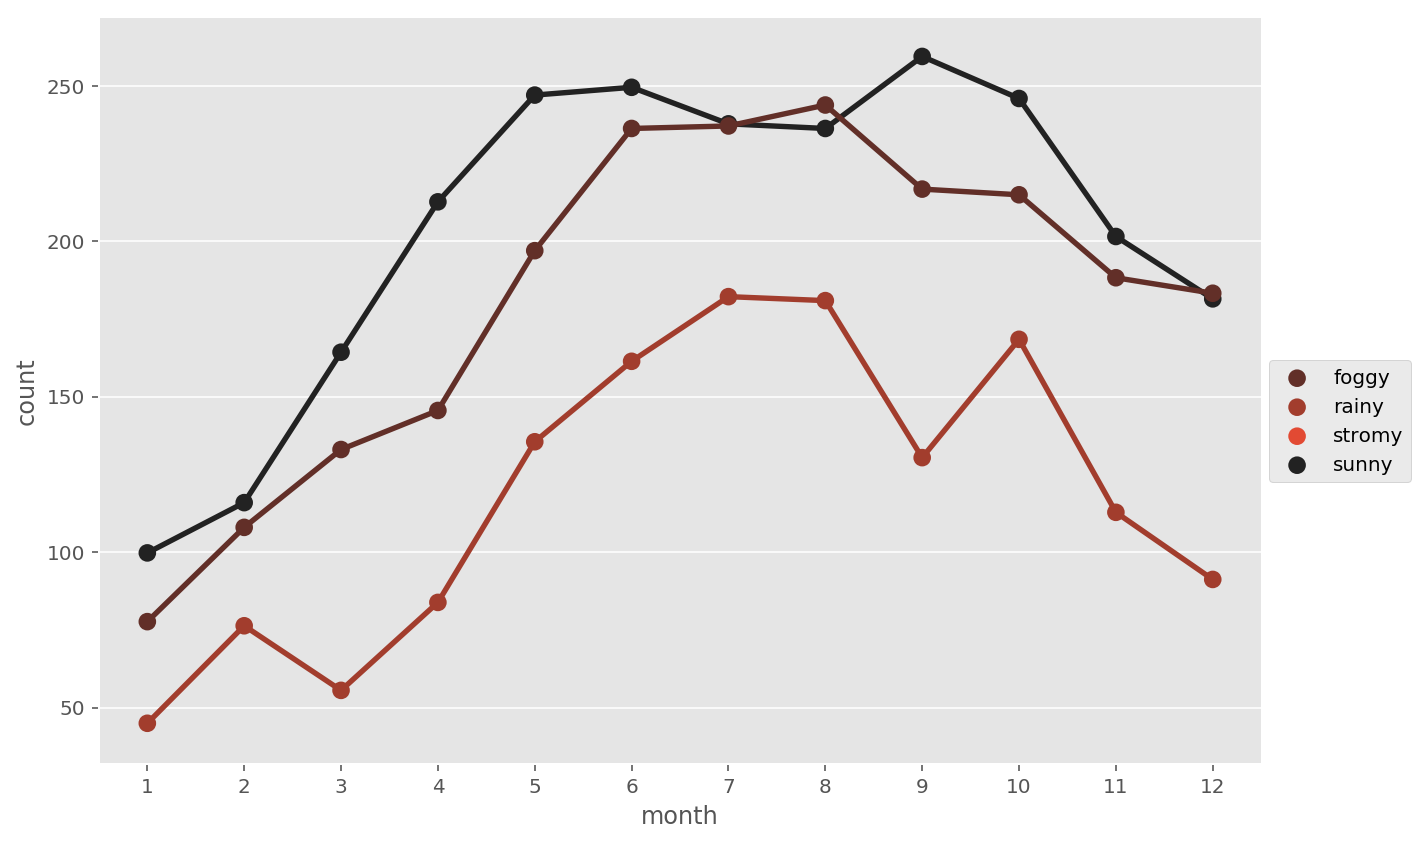

In [33]:
# 可视化呈现
sns.FacetGrid(data=BikeData,size=6,aspect=1.5).\
map(sns.pointplot,"month","count","weather_word",hue_order=["sunny","foggy","rainy","stromy"],paletter="deep",ci=None).\
add_legend()

- 天气越好，租车人数越多
- 5-10月租车人数最多-与天气、气候、营销宣传都有关系